## RAG with Bedrock Agents

RAG architecture have proven effective at leveraging knowledge bases to enhance foundation model outputs. However, for more complex queries that require reasoning over diverse information sources, a single monolithic RAG model can face limitations around relevance, latency, and coherence. Multi-agent architectures offer a powerful way to overcome these limitations by factoring RAG into specialized components. By dividing responsibilities like query understanding, retrieval, ranking, and language modeling across dedicated agents, each component can focus on its core capability using tailored models and data sources. This improves the overall relevance of retrieved information and generated responses.

In this lab, we are going to extend the Technical document assistant from previou Naive RAG lab and build an agent that can generate API flow diagram, create unit testing code, on top of original knowledge retrieval capabilities. Behind the scenes, the agent uses foundation model from Amazon Bedrock to orchestrate a set of tools and APIs as illustrated in the diagram below:

![Agent](../static/advance-agent-rag.png)


## Pre-req
You must run the notebook in [lab01](../lab01-managed-rag/) to load the necessary data to S3, and store the parameters for this lab.

In [1]:
import warnings
warnings.warn("Warning: if you did not run lab01, please go back and run the lab01 notebook!") 

/tmp/ipykernel_129/2588010541.py:2: UserWarning: Warning: if you did not run lab01, please go back and run the lab01 notebook!
  warnings.warn("Warning: if you did not run lab01, please go back and run the lab01 notebook!")


### > Setup and initalize

In [2]:
%pip install -U boto3
%pip install -U plantweb
%pip install -U opensearch-py==2.3.1
%pip install -U retrying==1.3.4

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.4/587.4 kB 21.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
import boto3
from botocore.config import Config
import time
import random
import pprint as pp
import uuid
import json
from retrying import retry
from utility import create_bedrock_execution_role, create_oss_policy_attach_bedrock_execution_role, create_policies_in_oss
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

# auth for opensearch
boto3_config = Config(
        connect_timeout=1, read_timeout=300,
        retries={'max_attempts': 1})

boto3_session = boto3.Session()
region_name = boto3_session.region_name
sts_client = boto3.client('sts')
account_id = sts_client.get_caller_identity()["Account"]
credentials = boto3_session.get_credentials()

# opensearch service
service = 'aoss'
awsauth = auth = AWSV4SignerAuth(credentials, region_name, service)


bedrock_agent_client = boto3_session.client('bedrock-agent', region_name=region_name)

# bucket and parameter stored from lab01
%store -r bucket
%store -r prefix
%store -r data_dir
%store -r yml_dir
%store -r uml_dir

## Create a vector store - OpenSearch Serverless index

### Step 1 - Create OSS policies and collection
Firt of all we have to create a vector store. In this section we will use *Amazon OpenSerach serverless.*

Amazon OpenSearch Serverless is a serverless option in Amazon OpenSearch Service. As a developer, you can use OpenSearch Serverless to run petabyte-scale workloads without configuring, managing, and scaling OpenSearch clusters. You get the same interactive millisecond response times as OpenSearch Service with the simplicity of a serverless environment. Pay only for what you use by automatically scaling resources to provide the right amount of capacity for your application—without impacting data ingestion.

In [2]:
suffix = random.randrange(200, 2000)
vector_store_name = f'swagger-api-{suffix}'
index_name = f"swagger-api-{suffix}"
aoss_client = boto3_session.client('opensearchserverless')
bedrock_kb_execution_role = create_bedrock_execution_role(bucket_name=bucket)
bedrock_kb_execution_role_arn = bedrock_kb_execution_role['Role']['Arn']

In [3]:
# create security, network and data access policies within OSS
encryption_policy, network_policy, access_policy = create_policies_in_oss(vector_store_name=vector_store_name,
                       aoss_client=aoss_client,
                       bedrock_kb_execution_role_arn=bedrock_kb_execution_role_arn)
collection = aoss_client.create_collection(name=vector_store_name,type='VECTORSEARCH')

In [4]:
pp.pprint(collection)
time.sleep(10)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '307',
                                      'content-type': 'application/x-amz-json-1.0',
                                      'date': 'Thu, 20 Jun 2024 16:00:25 GMT',
                                      'x-amzn-requestid': 'fec66697-0598-49a6-a568-d752519de5c2'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'fec66697-0598-49a6-a568-d752519de5c2',
                      'RetryAttempts': 0},
 'createCollectionDetail': {'arn': 'arn:aws:aoss:us-west-2:235384242854:collection/qzgrjb4r1dmvfcmsg7xl',
                            'createdDate': 1718899225216,
                            'id': 'qzgrjb4r1dmvfcmsg7xl',
                            'kmsKeyArn': 'auto',
                            'lastModifiedDate': 1718899225216,
                            'name': 'swagger-api-727',
                            'standbyReplicas': 'ENABLED',

In [5]:
collection_id = collection['createCollectionDetail']['id']
host = collection_id + '.' + region_name + '.aoss.amazonaws.com'
print(host)

qzgrjb4r1dmvfcmsg7xl.us-west-2.aoss.amazonaws.com


In [6]:
# create oss policy and attach it to Bedrock execution role
create_oss_policy_attach_bedrock_execution_role(collection_id=collection_id,
                                                bedrock_kb_execution_role=bedrock_kb_execution_role)

Opensearch serverless arn:  arn:aws:iam::235384242854:policy/AmazonBedrockOSSPolicyForKnowledgeBase_430


### Step 2 - Create vector index

In [7]:
index_name = f"bedrock-sample-index-{suffix}"
body_json = {
   "settings": {
      "index.knn": "true"
   },
   "mappings": {
      "properties": {
         "vector": {
            "type": "knn_vector",
            "dimension": 1536,
            "method": {
                "name": "hnsw",
                "space_type": "innerproduct",
                "engine": "faiss",
                "parameters": {
                  "ef_construction": 256,
                  "m": 48
                }
             }
         },
         "text": {
            "type": "text"
         },
         "text-metadata": {
            "type": "text"         
         }
      }
   }
}
# Build the OpenSearch client
oss_client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    timeout=300
)
# # It can take up to a minute for data access rules to be enforced
time.sleep(60)

In [8]:
# Create index
response = oss_client.indices.create(index=index_name, body=json.dumps(body_json))
print('\nCreating index:')
print(response)


Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'bedrock-sample-index-727'}


## Create Knowledge Base
Steps:
- initialize Open search serverless configuration which will include collection ARN, index name, vector field, text field and metadata field.
- initialize chunking strategy, based on which KB will split the documents into pieces of size equal to the chunk size mentioned in the `chunkingStrategyConfiguration`.
- initialize the s3 configuration, which will be used to create the data source object later.
- initialize the Titan embeddings model ARN, as this will be used to create the embeddings for each of the text chunks.

In [9]:
opensearchServerlessConfiguration = {
            "collectionArn": collection["createCollectionDetail"]['arn'],
            "vectorIndexName": index_name,
            "fieldMapping": {
                "vectorField": "vector",
                "textField": "text",
                "metadataField": "text-metadata"
            }
        }

chunkingStrategyConfiguration = {
    "chunkingStrategy": "NONE",
}

s3Configuration = {
    "bucketArn": f"arn:aws:s3:::{bucket}",
    "inclusionPrefixes":[f"{prefix}/{yml_dir.replace(data_dir+'/', '')}/"] # you can use this if you want to create a KB using data within s3 prefixes.
}

embeddingModelArn = f"arn:aws:bedrock:{region_name}::foundation-model/amazon.titan-embed-text-v1"

kb_name = f"bedrock-sample-knowledge-base-{suffix}"
description = "Swagger OpenAPI knowledge base."
roleArn = bedrock_kb_execution_role_arn

Provide the above configurations as input to the `create_knowledge_base` method, which will create the Knowledge base.

In [10]:
# Create a KnowledgeBase
from retrying import retry

@retry(wait_random_min=1000, wait_random_max=2000,stop_max_attempt_number=7)
def create_knowledge_base_func():
    create_kb_response = bedrock_agent_client.create_knowledge_base(
        name = kb_name,
        description = description,
        roleArn = roleArn,
        knowledgeBaseConfiguration = {
            "type": "VECTOR",
            "vectorKnowledgeBaseConfiguration": {
                "embeddingModelArn": embeddingModelArn
            }
        },
        storageConfiguration = {
            "type": "OPENSEARCH_SERVERLESS",
            "opensearchServerlessConfiguration":opensearchServerlessConfiguration
        }
    )
    return create_kb_response["knowledgeBase"]

In [11]:
try:
    kb = create_knowledge_base_func()
except Exception as err:
    print(f"{err=}, {type(err)=}")

Next we need to create a data source, which will be associated with the knowledge base created above. Once the data source is ready, we can then start to ingest the documents.

In [12]:
# Get KnowledgeBase 
get_kb_response = bedrock_agent_client.get_knowledge_base(knowledgeBaseId = kb['knowledgeBaseId'])

In [13]:
# Create a DataSource in KnowledgeBase 
create_ds_response = bedrock_agent_client.create_data_source(
    name = kb_name,
    description = description,
    knowledgeBaseId = kb['knowledgeBaseId'],
    dataSourceConfiguration = {
        "type": "S3",
        "s3Configuration":s3Configuration
    },
    vectorIngestionConfiguration = {
        "chunkingConfiguration": chunkingStrategyConfiguration
    }
)
ds = create_ds_response["dataSource"]
# # It can take up to a minute for data access rules to be enforced
time.sleep(20)
pp.pprint(ds)

{'createdAt': datetime.datetime(2024, 6, 20, 16, 1, 39, 205059, tzinfo=tzlocal()),
 'dataDeletionPolicy': 'DELETE',
 'dataSourceConfiguration': {'s3Configuration': {'bucketArn': 'arn:aws:s3:::sagemaker-us-west-2-235384242854',
                                                 'inclusionPrefixes': ['swagger_codegen/yml_files/']},
                             'type': 'S3'},
 'dataSourceId': 'TVUNMGXKAC',
 'description': 'Swagger OpenAPI knowledge base.',
 'knowledgeBaseId': '2T6EDNJFBG',
 'name': 'bedrock-sample-knowledge-base-727',
 'status': 'AVAILABLE',
 'updatedAt': datetime.datetime(2024, 6, 20, 16, 1, 39, 205059, tzinfo=tzlocal()),
 'vectorIngestionConfiguration': {'chunkingConfiguration': {'chunkingStrategy': 'NONE'}}}


### Start ingestion job
Once the KB and data source is created, we can start the ingestion job.
During the ingestion job, KB will fetch the documents in the data source, pre-process it to extract text, chunk it based on the chunking size provided, create embeddings of each chunk and then write it to the vector database, in this case OSS.

In [14]:
# Start an ingestion job
start_job_response = bedrock_agent_client.start_ingestion_job(knowledgeBaseId = kb['knowledgeBaseId'], dataSourceId = ds["dataSourceId"])

In [15]:
job = start_job_response["ingestionJob"]
pp.pprint(job)

{'dataSourceId': 'TVUNMGXKAC',
 'ingestionJobId': '8PO117KPVT',
 'knowledgeBaseId': '2T6EDNJFBG',
 'startedAt': datetime.datetime(2024, 6, 20, 16, 1, 59, 970047, tzinfo=tzlocal()),
 'statistics': {'numberOfDocumentsDeleted': 0,
                'numberOfDocumentsFailed': 0,
                'numberOfDocumentsScanned': 0,
                'numberOfMetadataDocumentsModified': 0,
                'numberOfMetadataDocumentsScanned': 0,
                'numberOfModifiedDocumentsIndexed': 0,
                'numberOfNewDocumentsIndexed': 0},
 'status': 'STARTING',
 'updatedAt': datetime.datetime(2024, 6, 20, 16, 1, 59, 970047, tzinfo=tzlocal())}


In [16]:
# Get job 
while(job['status']!='COMPLETE' ):
  get_job_response = bedrock_agent_client.get_ingestion_job(
      knowledgeBaseId = kb['knowledgeBaseId'],
        dataSourceId = ds["dataSourceId"],
        ingestionJobId = job["ingestionJobId"]
  )
  job = get_job_response["ingestionJob"]
pp.pprint(job)
time.sleep(80)

{'dataSourceId': 'TVUNMGXKAC',
 'ingestionJobId': '8PO117KPVT',
 'knowledgeBaseId': '2T6EDNJFBG',
 'startedAt': datetime.datetime(2024, 6, 20, 16, 1, 59, 970047, tzinfo=tzlocal()),
 'statistics': {'numberOfDocumentsDeleted': 0,
                'numberOfDocumentsFailed': 0,
                'numberOfDocumentsScanned': 5,
                'numberOfMetadataDocumentsModified': 0,
                'numberOfMetadataDocumentsScanned': 0,
                'numberOfModifiedDocumentsIndexed': 0,
                'numberOfNewDocumentsIndexed': 5},
 'status': 'COMPLETE',
 'updatedAt': datetime.datetime(2024, 6, 20, 16, 2, 12, 113667, tzinfo=tzlocal())}


In [17]:
kb_id = kb["knowledgeBaseId"]
%store kb_id
pp.pprint(kb_id)

Stored 'kb_id' (str)
'2T6EDNJFBG'


## Test the knowledge base
### Using RetrieveAndGenerate API
Behind the scenes, RetrieveAndGenerate API converts queries into embeddings, searches the knowledge base, and then augments the foundation model prompt with the search results as context information and returns the FM-generated response to the question. For multi-turn conversations, Knowledge Bases manage short-term memory of the conversation to provide more contextual results.

The output of the RetrieveAndGenerate API includes the generated response, source attribution as well as the retrieved text chunks.

In [18]:
# try out KB using RetrieveAndGenerate API
bedrock_agent_runtime_client = boto3_session.client("bedrock-agent-runtime", 
                                                    config=boto3_config)
model_id = "anthropic.claude-3-sonnet-20240229-v1:0" # try with both claude instant as well as claude-v2. for claude v2 - "anthropic.claude-v2"
model_arn = f'arn:aws:bedrock:{region_name}::foundation-model/{model_id}'

In [19]:
from IPython.display import Markdown, display

query = "How do I add a new pet to petstore? Can you generate a test code in python?"
response = bedrock_agent_runtime_client.retrieve_and_generate(
    input={
        'text': query
    },
    retrieveAndGenerateConfiguration={
        'type': 'KNOWLEDGE_BASE',
        'knowledgeBaseConfiguration': {
            'knowledgeBaseId': kb_id,
            'modelArn': model_arn
        }
    },
)

generated_text = response['output']['text']

display(Markdown(generated_text))

To add a new pet to the Petstore API, you need to send a POST request to the /pets endpoint with the pet details in the request body. According to the OpenAPI specification in source 5, the request body should contain a JSON object following the NewPet schema, which requires at least the "name" property. Here's an example Python code using the requests library to add a new pet:

import requests

url = "https://petstore.swagger.io/v2/pets"

payload = {
    "name": "Buddy",
    "tag": "dog"
}

headers = {
    'Content-Type': 'application/json'
}

response = requests.post(url, json=payload, headers=headers)

if response.status_code == 200:
    print("Pet added successfully!")
    print(response.json())
else:
    print(f"Error: {response.status_code} - {response.text}")

## Create the Lambda Function
We will now create a lambda function that to generate code and uml diagrams:

Create the lambda_function.py file which contains the logic for our lambda function
Create the IAM role for our Lambda function
Create the lambda function with the required permissions
Create the function code
When creating an Agent for Amazon Bedrock, you can connect a Lambda function to the Action Group in order to execute the functions required by the agent. 

In [20]:
%%writefile lambda_function.py
import json
import uuid
import boto3
from botocore.config import Config

boto_config = Config(
        connect_timeout=1, read_timeout=300,
        retries={'max_attempts': 1})

boto_session = boto3.Session()

bedrock_runtime = boto_session.client(
    service_name="bedrock-runtime",
    config=boto_config
)

code_generation = """
Your task is to generate a code snippet based on a given OpenAPI YAML file and a user query. The
YAML file will be provided in the following format:

<YAML_FILE>
{YAML_FILE}
</YAML_FILE>

The user query will be provided like this:

<USER_QUERY>
{USER_QUERY}
</USER_QUERY>

To complete this task, follow these steps:

1. Carefully read and understand the user query. Identify the specific API endpoint, HTTP method,
and any required parameters or request body mentioned in the query.

2. Analyze the provided YAML file and locate the relevant section that corresponds to the user's
query. The YAML file follows the OpenAPI specification and contains information about the API's
endpoints, methods, parameters, request/response bodies, etc.

3. Once you have identified the relevant section in the YAML file, extract the necessary information
to construct the code snippet, such as the endpoint URL, HTTP method, required parameters, and
request body structure (if applicable).

4. Use the extracted information to generate the code snippet in the programming language specified
by the user (e.g., Python, JavaScript, etc.). The code snippet should include the necessary
imports/libraries, the API endpoint URL, the HTTP method, any required parameters, and the request
body (if applicable).

5. Format the generated code snippet using markdown code blocks, like this:

```<programming_language>
<code_snippet>
```

This will allow the user to easily copy and paste the code snippet.

6. If the user's query cannot be fulfilled based on the provided YAML file, or if there is any
ambiguity or missing information, explain the issue politely and ask for clarification from the
user.

Remember, your goal is to generate a code snippet that accurately reflects the user's query based on
the information provided in the OpenAPI YAML file. Do not include any additional functionality or
code beyond what is necessary to fulfill the user's request.
"""


uml_generation = """
Your task is to generate a UML Sequential plantuml code snippet based on a given OpenAPI YAML file . The
YAML file will be provided in the following format:

<YAML_FILE>
{YAML_FILE}
</YAML_FILE>

Here are the steps you should follow:

1. Read the provided <yaml> carefully and understand the APIs, their
endpoints, request/response data structures, and other details.

<yaml>
{YAML_FILE}
</yaml>

2. In the <PlantUML> field, generate the UML Sequential Plantuml code generated after looking at YAML file. Make sure you are looking at all the elements of YAML file as you generate the plantuml code.

3. Structure your JSON output as follows:

{
"PlantUML": "<PlantUML>"
}

4. Replace <PlantUML> with the appropriate content you generated in the previous steps.

Please provide your response in JSON format only, without any additional explanations or comments.
"""

uml_generation1 = """
Your task is to generate a UML Sequential plantuml code snippet based on a given OpenAPI YAML file . The
YAML file will be provided in the following format:

<YAML_FILE>
{YAML_FILE}
</YAML_FILE>

Here are the steps you should follow:

1. Read the provided <yaml> carefully and understand the APIs, their
endpoints, request/response data structures, and other details.

<yaml>
{YAML_FILE}
</yaml>

2. Format the generated code snippet using markdown code blocks, like this:

```<programming_language>
<code_snippet>
```

This will allow the user to easily copy and paste the code snippet.


Remember, your goal is to generate a code snippet that accurately reflects input OpenAPI YAML in UML Sequential PlantUML code. Do not include any additional functionality or
code beyond what is necessary to fulfill the user's request.
"""

def get_named_parameter(event, name):
    """
    Get a parameter from the lambda event
    """
    return next(item for item in event['parameters'] if item['name'] == name)['value']

def get_uml_diagram(yml_code):
    """
    Get a UML Diagram

    Save image to S3
    """
    content = []

    prompt = uml_generation1.replace("{YAML_FILE}",yml_code)

    query_obj = {"type": "text", "text": prompt}

    content.append(query_obj)

    body = json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 4096,
            "messages": [
                {
                    "role": "user",
                    "content": content,
                }
            ],
        }
    )
    
    response = bedrock_runtime.invoke_model(
        modelId="anthropic.claude-3-sonnet-20240229-v1:0",
        body=body)
    
    response_body = json.loads(response.get("body").read())
    
    return {"codeBody": response_body["content"][0]["text"]}

def get_unit_test_code(yml_code, query):
    """
    Generate unit test code to invoke an API
    
    """
    content = []

    prompt = code_generation.replace("{YAML_FILE}",yml_code)
    prompt = prompt.replace("{USER_QUERY}",query)

    query_obj = {"type": "text", "text": prompt}

    content.append(query_obj)

    body = json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 4096,
            "messages": [
                {
                    "role": "user",
                    "content": content,
                }
            ],
        }
    )
    
    response = bedrock_runtime.invoke_model(
        modelId="anthropic.claude-3-sonnet-20240229-v1:0",
        body=body)
    
    response_body = json.loads(response.get("body").read())
    
    return {"codeBody": response_body["content"][0]["text"]}

def lambda_handler(event, context):
    # get the action group used during the invocation of the lambda function
    actionGroup = event.get('actionGroup', '')
    
    # name of the function that should be invoked
    function = event.get('function', '')
    
    # parameters to invoke function with
    parameters = event.get('parameters', [])

    if function == 'get_uml_diagram':
        yml_code = get_named_parameter(event, "yml_body")
        
        if yml_code:
            response = get_uml_diagram(yml_code)
            responseBody = {'TEXT': {'body': json.dumps(response)}}
        else:
            responseBody = {'TEXT': {'body': 'Missing YML code.'}}

    elif function == 'get_unit_test_code':
        yml_code = get_named_parameter(event, "yml_body")
        user_query = get_named_parameter(event, "user_query")

        if yml_code:
            response = get_unit_test_code(yml_code, user_query)
            responseBody = {'TEXT': {'body': json.dumps(response)}}
        else:
            responseBody = {'TEXT': {'body': 'Missing YML code.'}}

    else:
        responseBody = {'TEXT': {'body': 'Invalid function'}}

    action_response = {
        'actionGroup': actionGroup,
        'function': function,
        'functionResponse': {
            'responseBody': responseBody
        }
    }

    function_response = {'response': action_response, 'messageVersion': event['messageVersion']}
    print("Response: {}".format(function_response))

    return function_response


Overwriting lambda_function.py


In [21]:
from utility import create_lambda_role
from utility import create_lambda

agent_name = f'swagger-api-agent-{suffix}'
lambda_iam_role = create_lambda_role(agent_name)

### Create the function
Now that we have the Lambda function code and its execution role, let's package it into a Zip file and create the Lambda resources

In [22]:
lambda_function_name = f'{agent_name}-lambda'
lambda_function = create_lambda(lambda_function_name, lambda_iam_role)

## Create the Agent
Once the needed IAM role is created, we can use the bedrock agent client to create a new agent. To do so we use the create_agent api from boto3. It requires an agent name, underline foundation model and instruction. You can also provide an agent description. Note that the agent created is not yet prepared. We will focus on preparing the agent and then using it to invoke actions and use other APIs

In [23]:
agent_instruction = """
You are an agent designed to support users with coding questions related to Swagger APIs. You have access to the Swagger
documentation in a Knowledge Base and you can answer questions from this document or use document as referecne to generate
code or uml flow diagrams. Only answer questions based on the documentation and reply with "There is no information about your 
question in the Documentation at the moment, sorry! Do you want to ask another question?"  If the answer to the question 
is not available in the documentation
"""

agent_action_group_description = """
Actions for generating test code and uml diagrams
"""

In [24]:
response = bedrock_agent_client.create_agent(
    agentName=agent_name,
    agentResourceRoleArn=roleArn,
    description="This Agent supports Swagger API Developers to answer question, generate code, or create uml flow diagrams",
    idleSessionTTLInSeconds=1800,
    foundationModel=model_id,
    instruction=agent_instruction,
)

agent_id = response['agent']['agentId']
agent_id

'X2NMD7UPIS'

## Create the Agent Action Group

We will now create an agent action group that uses the lambda function created before. The create_agent_action_group function provides this functionality. We will use DRAFT as the agent version since we haven't yet created an agent version or alias. To inform the agent about the action group functionalities, we will provide an action group description containing the functionalities of the action group.

In this example, we will provide the Action Group functionality using a functionSchema.

To define the functions using a function schema, you need to provide the name, description and parameters for each function.

In [25]:
agent_functions = [
    {
        'name': 'get_uml_diagram',
        'description': 'Generate a UML flow diagram referencing the OpenAPI API specification. the function return S3 location of the image ONLY.',
        'parameters': {
            "yml_body": {
                "description": "openapi standard yml file of the swagger api",
                "required": True,
                "type": "string"
            }
        }
    },
    {
        'name': 'get_unit_test_code',
        'description': 'Generate functional testing code referencing the OpenAPI API specification. the function returns the code snippet.',
        'parameters': {
            "yml_body": {
                "description": "openapi standard yml file of the swagger api",
                "required": True,
                "type": "string"
            },
            "user_query": {
                "description": "question from user or code user wants to generate",
                "required": True,
                "type": "string"
            }
        }
    },
]

We now use the function schema to create the agent action group using the create_agent_action_group API

In [26]:
# Pause to make sure agent is created
time.sleep(40)

# Now, we can configure and create an action group here:
agent_action_group_response = bedrock_agent_client.create_agent_action_group(
    agentId=agent_id,
    agentVersion='DRAFT',
    actionGroupExecutor={
        'lambda': lambda_function['FunctionArn']
    },
    actionGroupName="CodeAndDiagramActionGroup",
    functionSchema={
        'functions': agent_functions
    },
    description=agent_action_group_description
)

## Allow the Agent to invoke the Action Group Lambda
Before using the action group, we need to allow the agent to invoke the lambda function associated with the action group. This is done via resource-based policy. Let's add the resource-based policy to the lambda function created

In [27]:
# Create allow to invoke permission on lambda
lambda_client = boto3.client('lambda')
response = lambda_client.add_permission(
    FunctionName=lambda_function_name,
    StatementId='allow_bedrock',
    Action='lambda:InvokeFunction',
    Principal='bedrock.amazonaws.com',
    SourceArn=f"arn:aws:bedrock:{region_name}:{account_id}:agent/{agent_id}",
)

## Associate the Knowledge Base to the agent
Now we have created the Agent we can go ahead and associate the Knowledge Base we created earlier.

In [28]:
agent_kb_description = bedrock_agent_client.associate_agent_knowledge_base(
    agentId=agent_id,
    agentVersion='DRAFT',
    description=f'Use the information in the {kb_name} knowledge base to retrieve OpenAPI Specification in YML format',
    knowledgeBaseId=kb_id,
    knowledgeBaseState='ENABLED'
)

## Prepare the Agent and create an alias
Let's create a DRAFT version of the agent that can be used for internal testing.

In [29]:
agent_prepare = bedrock_agent_client.prepare_agent(agentId=agent_id)
agent_prepare
time.sleep(30)

In [30]:
# Pause to make sure agent is prepared
agent_alias_name = f"swagger-docs-action-alias-{suffix}5"

agent_alias = bedrock_agent_client.create_agent_alias(
    agentId=agent_id,
    agentAliasName=agent_alias_name
)
agent_alias_id = agent_alias["agentAlias"]["agentAliasId"]

# Pause to make sure agent alias is ready
time.sleep(60)

## Test the Agent
Now that we've created the agent, let's use the bedrock-agent-runtime client to invoke this agent and perform some tasks. You can invoke your agent with the invoke_agent API

In [31]:
def invokeAgent(query, session_id, enable_trace=False, session_state=dict()):
    end_session:bool = False
    
    # invoke the agent API
    agentResponse = bedrock_agent_runtime_client.invoke_agent(
        inputText=query,
        agentId=agent_id,
        agentAliasId=agent_alias_id, 
        sessionId=session_id,
        enableTrace=enable_trace, 
        endSession= end_session,
        sessionState=session_state
    )
    
    if enable_trace:
        pp.pprint(agentResponse)
    
    event_stream = agentResponse['completion']
    try:
        for event in event_stream:        
            if 'chunk' in event:
                data = event['chunk']['bytes']
                if enable_trace:
                    pp.pprint(f"Final answer ->\n{data.decode('utf8')}")
                agent_answer = data.decode('utf8')
                end_event_received = True
                return agent_answer
                # End event indicates that the request finished successfully
            elif 'trace' in event:
                if enable_trace:
                    pp.pprint(json.dumps(event['trace'], indent=2))
            else:
                raise Exception("unexpected event.", event)
    except Exception as e:
        raise Exception("unexpected event.", e)

Invoke Agent to query Knowledge Base
Let's now use our support `invokeAgent` function to query our Knowledge Base with the Agent

## Generating UML Sequential Diagrams

We will generate PlantUML Code for our API and then use PlantWeb to generate the UML Sequential diagram.

In [32]:
%%time
import uuid
session_id:str = str(uuid.uuid1())
query = "can you generate plantuml code for the petstore swagger api?" #"How do I add a new pet using the petstore api? Can you generate a test code in python?" #
response = invokeAgent(query, session_id, enable_trace=False)
display(Markdown(response))
#print(response)

The PlantUML code generated for the Petstore Swagger API is:

```plantuml
@startuml
actor User

box "Petstore API" #LightBlue
participant PetsController

User -> PetsController: GET /pets?limit=10
activate PetsController
PetsController -> User: 200 Pets
deactivate PetsController

User -> PetsController: POST /pets
activate PetsController
PetsController -> User: 201 Created
deactivate PetsController

User -> PetsController: GET /pets/{petId}
activate PetsController
PetsController -> User: 200 Pet
deactivate PetsController

User -> PetsController: DELETE /pets/{petId}
activate PetsController
PetsController -> User: 204 No Content
deactivate PetsController

@enduml
```

This diagram accurately represents the API endpoints and their request/response interactions as described in the provided OpenAPI specification. It includes:

1. GET /pets to list all pets with an optional limit query parameter
2. POST /pets to create a new pet  
3. GET /pets/{petId} to retrieve information for a specific pet
4. DELETE /pets/{petId} to delete a specific pet

The diagram shows the interactions between the User and the PetsController within the Petstore API, including the HTTP methods, paths, status codes, and response body types.

CPU times: user 16.5 ms, sys: 3.43 ms, total: 20 ms
Wall time: 1min 5s


In [38]:
%%writefile petstore.dot
@startuml
actor User

box "Petstore API" #LightBlue
participant PetsController

User -> PetsController: GET /pets?limit=10
activate PetsController
PetsController -> User: 200 Pets
deactivate PetsController

User -> PetsController: POST /pets
activate PetsController
PetsController -> User: 201 Created
deactivate PetsController

User -> PetsController: GET /pets/{petId}
activate PetsController
PetsController -> User: 200 Pet
deactivate PetsController

User -> PetsController: DELETE /pets/{petId}
activate PetsController
PetsController -> User: 204 No Content
deactivate PetsController

@enduml

Overwriting petstore.dot


In [39]:
!plantweb petstore.dot

Writing output for /home/sagemaker-user/aws-genai-rag-workshop/lab03-advance-rag-agent/petstore.dot to petstore.svg


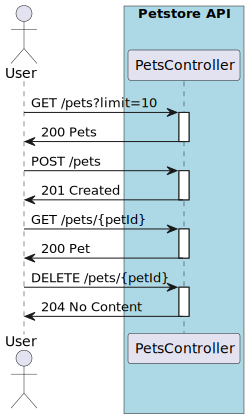

In [40]:
from IPython.display import SVG, display
display(SVG('petstore.svg'))

## Generating Python Code for a sample API. 

In [41]:
%%time
import uuid
session_id:str = str(uuid.uuid1())
query = "How do I add a new pet using the petstore api? Can you generate a test code in python?"
response = invokeAgent(query, session_id, enable_trace=False)
display(Markdown(response))

Here is Python test code to add a new pet to the Petstore API:

```python
import requests

url = "https://petstore.swagger.io/v2/pets"

payload = {
    "name": "Buddy",
    "tag": "dog"
}

headers = {
    'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, json=payload)

if response.status_code == 201:
    print("Pet created successfully")
else:
    print(f"Error creating pet: {response.text}")
```

This code:

1. Imports the requests library to make HTTP requests
2. Sets the URL for the /pets endpoint to create a new pet
3. Creates a payload dictionary with the required name and tag fields for the new pet
4. Sets the required Content-Type header for a JSON request
5. Sends a POST request to the /pets endpoint with the payload and headers
6. Checks the response status code - 201 means the pet was created successfully
7. Prints a success or error message based on the response

To run this, you'll need to have the requests library installed (pip install requests).

CPU times: user 17.3 ms, sys: 3.69 ms, total: 21 ms
Wall time: 1min


In [42]:
#%%time
#import uuid
#session_id:str = str(uuid.uuid1())
#query = "can you generate UML diagram for the bookstore swagger api?" #"How do I add a new pet using the petstore api? Can you generate a test code in python?" #
#response = invokeAgent(query, session_id, enable_trace=False)
#display(Markdown(response))
##print(response)

Unfortunately, there is not enough information in the provided OpenAPI specification to generate a meaningful UML diagram for the Bookstore API. The specification only contains high-level metadata about the API, but does not provide details on the specific endpoints, request/response data structures, or interactions between components that would be needed to create an accurate sequence or other UML diagram. Without those lower-level implementation details in the specification, the tool cannot generate a useful diagram. My apologies, but based on the information available in the knowledge base, I cannot generate a UML diagram for this API at this time.

CPU times: user 13.9 ms, sys: 3.85 ms, total: 17.8 ms
Wall time: 47.9 s
